In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

### Reading the data and remove redundany

In [55]:
data = pd.read_csv("cleaned_data.csv")
data = data.map(lambda x: 1 if x is True else (0 if x is False else x))
data = data.drop(columns=data.columns[0])
data[:5]

,Monthly_Usage_kWh,Year,Household_Size,Income_Level,Adoption_Year,Cost_Savings_USD,Energy_Source_Geothermal,Energy_Source_Hydro,Energy_Source_Solar,Energy_Source_Wind,Urban_Rural_Urban,Subsidy_Received_Yes
0,1043.49,2024,5,0,2012,10.46,0,1,0,0,1,0
1,610.01,2024,4,2,2023,43.49,1,0,0,0,0,0
2,1196.75,2024,8,0,2017,93.28,0,0,0,0,0,1
3,629.67,2024,7,2,2023,472.85,0,0,0,0,1,0
4,274.46,2022,7,1,2010,65.98,0,1,0,0,0,0


# 1. Unsupervised-learning

## a) K-Means clustering -> not sufficient

In [56]:
df = data.copy()

### i) Apply PCA and K-means

In [57]:
# Turn several columns to 2 principal components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df)
pca_data[:3]

array([[ 276.12489513, -237.97546274],
       [-157.35135124, -204.87277346],
       [ 429.39765287, -155.18313205]])

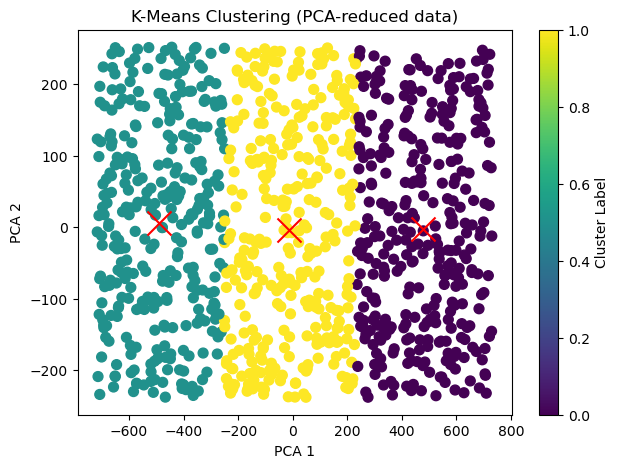

In [58]:
kmeans = KMeans(n_clusters=3, random_state=27)
kmeans.fit(pca_data)
labels = kmeans.labels_
df['Cluster'] = labels

plt.figure(figsize=(7,5))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap="viridis", s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c='red', marker='x') # Plot centroids
plt.title("K-Means Clustering (PCA-reduced data)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster Label")
plt.show()


Here are the statistics about each cluster

In [59]:
for cluster in range(kmeans.n_clusters):
    print(f"\nCluster {cluster} Statistics:")
    cluster_data = df[df['Cluster'] == cluster]
    print(cluster_data.describe())  


Cluster 0 Statistics:
       Monthly_Usage_kWh         Year  Household_Size  Income_Level  \
count         341.000000   341.000000      341.000000    341.000000   
mean         1245.567331  2021.941349        4.316716      0.973607   
std           144.593936     1.433657        2.317323      0.779824   
min          1001.420000  2020.000000        1.000000      0.000000   
25%          1108.740000  2021.000000        2.000000      0.000000   
50%          1244.820000  2022.000000        4.000000      1.000000   
75%          1359.830000  2023.000000        6.000000      2.000000   
max          1497.340000  2024.000000        8.000000      2.000000   

       Adoption_Year  Cost_Savings_USD  Energy_Source_Geothermal  \
count     341.000000        341.000000                341.000000   
mean     2015.991202        246.222229                  0.170088   
std         3.932135        140.291390                  0.376262   
min      2010.000000         10.460000                  0.000000 

### ii) Revert data to its original format

However, we are using preprocessed data, so after applying clustering, we revert it back to the original format of numeric(non-standardized) and categorial data

In [60]:
from sklearn.preprocessing import StandardScaler

# Load original unscaled data (unscaled)
original_df = pd.read_csv('raw.csv') 

# Fit scaler only to numeric columns
num_cols = ['Monthly_Usage_kWh', 'Household_Size', 'Cost_Savings_USD', 'Adoption_Year']

# Recreate scaler to reverse scaling later
scaler = StandardScaler()
scaler.fit(original_df[num_cols])  

# Get scaled numeric values from your cluster
cluster_scaled_data = cluster_data[num_cols]

# Inverse the scaling
cluster_unscaled = pd.DataFrame(scaler.inverse_transform(cluster_scaled_data), 
                                columns=num_cols, index=cluster_scaled_data.index)

In [61]:
income_reverse_map = {0: 'Low', 1: 'Middle', 2: 'High'}
urban_reverse_map = {1: 'Urban', 0: 'Rural'}
subsidy_reverse_map = {1: 'Yes', 0: 'No'}

df['Income_Level'] = df['Income_Level'].map(income_reverse_map)
df['Urban_Rural'] = df['Urban_Rural_Urban'].map(urban_reverse_map)
df['Subsidy_Received'] = df['Subsidy_Received_Yes'].map(subsidy_reverse_map)

In [62]:
# Reverse onehot encoder from the preprocessing step
def reverse_one_hot(df, prefix):
    cols = [col for col in df.columns if col.startswith(prefix + '_')]
    return df[cols].idxmax(axis=1).str.replace(f'{prefix}_', '')

df['Energy_Source'] = reverse_one_hot(df, 'Energy_Source')

### iii) Extract meaning from clusters

In [63]:
for cluster in range(kmeans.n_clusters):
    print(f"\n=== Cluster {cluster} Summary ===")
    cluster_data = df[df['Cluster'] == cluster]

    # Categorical summary (mode)
    print("\n- Top Categorical Values:")
    # cat_summary = cluster_data[['Region', 'Country', 'Energy_Source', 
    #                             'Income_Level', 'Urban_Rural', 'Subsidy_Received']].mode().iloc[0]
    cat_summary = cluster_data[['Energy_Source', 'Income_Level', 'Urban_Rural', 'Subsidy_Received_Yes']].mode().iloc[0]
    
    print(cat_summary)

    # Numeric summary (mean)
    print("\n- Numeric Averages:")
    # Inverse transform scaled numeric data
    cluster_scaled_data = cluster_data[num_cols]
    cluster_unscaled = pd.DataFrame(scaler.inverse_transform(cluster_scaled_data), 
                                    columns=num_cols, index=cluster_scaled_data.index)

    print(cluster_unscaled.mean().round(2))



=== Cluster 0 Summary ===

- Top Categorical Values:
Energy_Source           Geothermal
Income_Level                Middle
Urban_Rural                  Rural
Subsidy_Received_Yes             0
Name: 0, dtype: object

- Numeric Averages:
Monthly_Usage_kWh    523207.12
Household_Size           14.39
Cost_Savings_USD      35471.89
Adoption_Year         10022.79
dtype: float64

=== Cluster 1 Summary ===

- Top Categorical Values:
Energy_Source           Geothermal
Income_Level                  High
Urban_Rural                  Rural
Subsidy_Received_Yes             0
Name: 0, dtype: object

- Numeric Averages:
Monthly_Usage_kWh    117709.47
Household_Size           14.85
Cost_Savings_USD      36655.82
Adoption_Year         10022.91
dtype: float64

=== Cluster 2 Summary ===

- Top Categorical Values:
Energy_Source           Geothermal
Income_Level                Middle
Urban_Rural                  Urban
Subsidy_Received_Yes             1
Name: 0, dtype: object

- Numeric Averages:
Monthly_

## b) K Prototypes

### i) Making Clusters

In [64]:
from kmodes.kprototypes import KPrototypes

df = pd.read_csv("raw.csv")
df = df.drop(columns=["Household_ID", "Region"])

categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categorical_indexes = [df.columns.get_loc(col) for col in categorical_columns]

# Perform K-prototype clustering
kproto = KPrototypes(n_clusters=10, init='Cao', verbose=0)
clusters = kproto.fit_predict(df.to_numpy(), categorical=categorical_indexes)

### ii) Displaying clusters info

In [65]:
# Display cluster

numerical_columns = df.select_dtypes(exclude=['object', 'category']).columns
# Find correct order of the columns name because kprototype change it 
correct_column_order = list(numerical_columns) + list(categorical_columns) 

# Turn clusters into DataFrame
centroids_df = pd.DataFrame(kproto.cluster_centroids_, columns=correct_column_order)

columns_to_round = ["Year", "Adoption_Year"]  
centroids_df[columns_to_round] = centroids_df[columns_to_round].astype(float).round(0).astype(int)
columns_to_round = ["Monthly_Usage_kWh", "Cost_Savings_USD", "Household_Size"]  
centroids_df[columns_to_round] = centroids_df[columns_to_round].astype(float).round(2)

centroids_df.index = [f'Cluster {i}' for i in range(kproto.n_clusters)]
centroids_df

,Monthly_Usage_kWh,Year,Household_Size,Adoption_Year,Cost_Savings_USD,Country,Energy_Source,Income_Level,Urban_Rural,Subsidy_Received
Cluster 0,198.22,2022,4.59,2017,118.85,New Zealand,Solar,High,Rural,No
Cluster 1,980.04,2022,4.79,2016,396.88,Australia,Solar,Middle,Rural,No
Cluster 2,531.14,2022,4.56,2016,120.77,Canada,Wind,High,Rural,Yes
Cluster 3,685.81,2022,4.09,2016,384.24,Australia,Wind,Low,Urban,Yes
Cluster 4,383.84,2022,4.46,2016,359.42,New Zealand,Solar,High,Urban,Yes
Cluster 5,1087.37,2022,4.57,2016,141.66,Australia,Hydro,Middle,Urban,No
Cluster 6,137.65,2022,4.44,2016,356.38,Canada,Wind,Low,Rural,No
Cluster 7,1354.94,2022,4.22,2016,139.82,Mexico,Hydro,Middle,Rural,Yes
Cluster 8,812.90,2022,4.92,2016,135.71,New Zealand,Solar,High,Urban,Yes
Cluster 9,1328.09,2022,4.17,2016,386.88,China,Wind,Low,Rural,No


### iii) Making predictions

In [66]:
df[:3]

,Country,Energy_Source,Monthly_Usage_kWh,Year,Household_Size,Income_Level,Urban_Rural,Adoption_Year,Subsidy_Received,Cost_Savings_USD
0,USA,Hydro,1043.49,2024,5,Low,Urban,2012,No,10.46
1,Australia,Geothermal,610.01,2024,4,High,Rural,2023,No,43.49
2,USA,Biomass,1196.75,2024,8,Low,Rural,2017,Yes,93.28


In [67]:
cluster_labels = {
    0: "Heavy Users in Underserved Areas",
    1: "High Impact Rural Households",
    2: "Minimal Users with Strong Means",
    3: "Urban Subsidized Adopters",
    4: "Budget-Conscious Urban Beneficiaries",
    5: "Efficient Urban Savers",
    6: "High Consumers with Low Returns",
    7: "Frugal Households with High Gains",
    8: "Urban Energy Spenders",
    9: "Wealthy Subsidized Consumers"
}
columns = df.columns.tolist()


sample = pd.DataFrame([{
    "Monthly_Usage_kWh": 950.0,
    "Year": 2022,
    "Household_Size": 4.6,
    "Adoption_Year": 2017,
    "Cost_Savings_USD": 300.0,
    "Country": "Australia",
    "Energy_Source": "Solar",
    "Income_Level": "Middle",
    "Urban_Rural": "Urban",
    "Subsidy_Received": "Yes"
}])[columns]  # ensure correct column order

cluster_id = kproto.predict(sample.to_numpy(), categorical=categorical_indexes)[0]
user_label = cluster_labels[cluster_id]
print(f"Cluster {cluster_id}: {user_label}")

Cluster 1: High Impact Rural Households


### iv) Saving the model

In [68]:
import pickle

with open("K_Prototypes.pkl", "wb") as f:
    pickle.dump(kproto, f)

# 2. Supervised learning

## a) Random forest

### i) Preparing data

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [70]:
df = data.copy()
df[:5]

,Monthly_Usage_kWh,Year,Household_Size,Income_Level,Adoption_Year,Cost_Savings_USD,Energy_Source_Geothermal,Energy_Source_Hydro,Energy_Source_Solar,Energy_Source_Wind,Urban_Rural_Urban,Subsidy_Received_Yes
0,1043.49,2024,5,0,2012,10.46,0,1,0,0,1,0
1,610.01,2024,4,2,2023,43.49,1,0,0,0,0,0
2,1196.75,2024,8,0,2017,93.28,0,0,0,0,0,1
3,629.67,2024,7,2,2023,472.85,0,0,0,0,1,0
4,274.46,2022,7,1,2010,65.98,0,1,0,0,0,0


In [71]:
threshold = df["Cost_Savings_USD"].median()
df["High_Savings"] = (df["Cost_Savings_USD"] > threshold).astype(int)
# Drop target and irrelevant columns
x = df.drop(columns=["High_Savings", "Cost_Savings_USD"])

y = df["High_Savings"]

In [72]:
# Splitting into training and testing dataset (80:20)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=27)
X_train.shape, y_train.shape

((800, 11), (800,))

### ii) Create and train the model

In [73]:
model = RandomForestClassifier(n_estimators=100, random_state=27)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=27)

### iii) Evaluation

In [74]:
scores = cross_val_score(model, x, y, cv=5, scoring='f1')
print("Average F1 score:", scores.mean())

Average F1 score: 0.5073315536228452


In [75]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.55      0.54       101
           1       0.51      0.47      0.49        99

    accuracy                           0.52       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.51      0.52      0.51       200



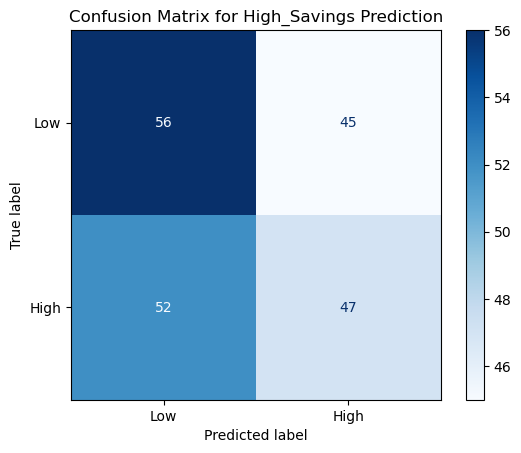

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "High"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for High_Savings Prediction")
plt.show()

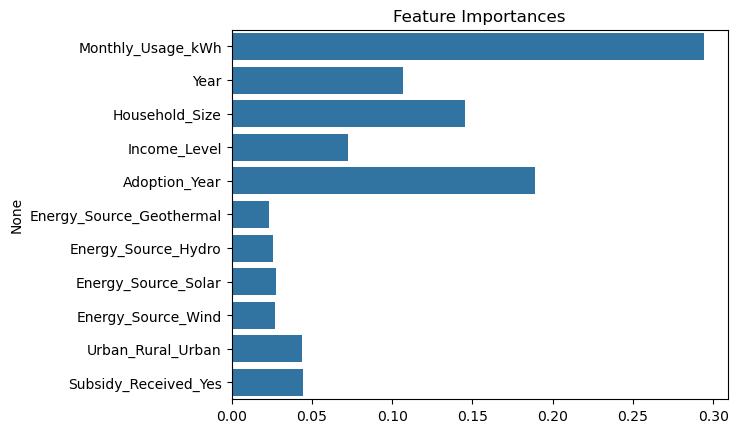

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.Series(model.feature_importances_, index=x.columns)
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Feature Importances")
plt.show()

### iv) Making prediction

In [78]:
sample = np.array([1043.49,2024,5,0,2012,False,True,False,False,True,False])
pred = model.predict(X=[sample])
model.feature_names_in_, pred

/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


(array(['Monthly_Usage_kWh', 'Year', 'Household_Size', 'Income_Level',
        'Adoption_Year', 'Energy_Source_Geothermal', 'Energy_Source_Hydro',
        'Energy_Source_Solar', 'Energy_Source_Wind', 'Urban_Rural_Urban',
        'Subsidy_Received_Yes'], dtype=object),
 array([0]))

## b) Random forest regressor

### i) Preparing data

In [79]:
# df = pd.read_csv("raw.csv")
# for i in df:
#     if(df[i].dtype == "object") and ( i != "Household_ID"):
#         df = pd.get_dummies(df, columns = [i])
# df = df.map(lambda x: 1 if x is True else (0 if x is False else x))
# df = df.drop(columns=df.columns[0])

# x = df.drop(columns=["Cost_Savings_USD"])
# pca = PCA(n_components=5)
# x = pca.fit_transform(x)

# y = df["Cost_Savings_USD"]
# # y = np.log1p(df["Cost_Savings_USD"])

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

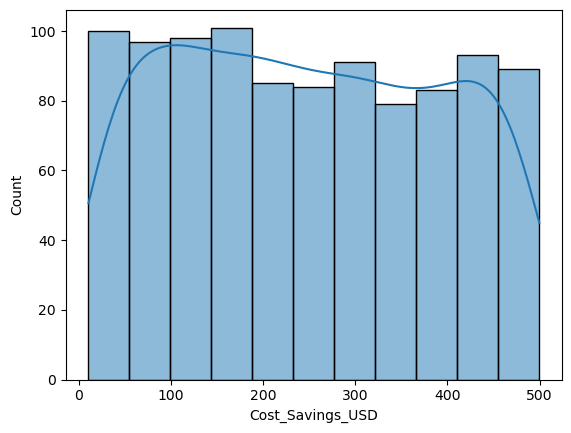

In [80]:
df = data.copy()
sns.histplot(df["Cost_Savings_USD"], kde=True)
plt.show()

x = df.drop(columns=["Cost_Savings_USD"])
y = df["Cost_Savings_USD"]
# y = np.log1p(df["Cost_Savings_USD"])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Testing with a simple dataset to see if the data is the problem or the code is => the data is screwed

In [81]:
# df = pd.read_csv("salary.csv")

# x = df.drop(columns=["salary"])
# # y = df["Cost_Savings_USD"]
# y = np.log1p(df["salary"])

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

### ii) Create and train the model

In [87]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

# y_train = np.array(y_train).reshape(-1, 1)
# y_test = np.array(y_test).reshape(-1, 1)

# Create and train the model
model = RandomForestRegressor(n_estimators=100, random_state=27)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R^2 Score Test:", r2_score(y_true=y_test, y_pred=y_pred))

# y_pred = model.predict(X_train)
# print("R^2 Score Train:", r2_score(y_train,y_pred))

# y_predict_train = model.predict(X_train)
# r2_train = r2_score(y_true = y_train, y_pred = y_predict_train)
# r2_train

RMSE: 149.76445501977278
R^2 Score Test: -0.132605353180838


### iii) Evaluation

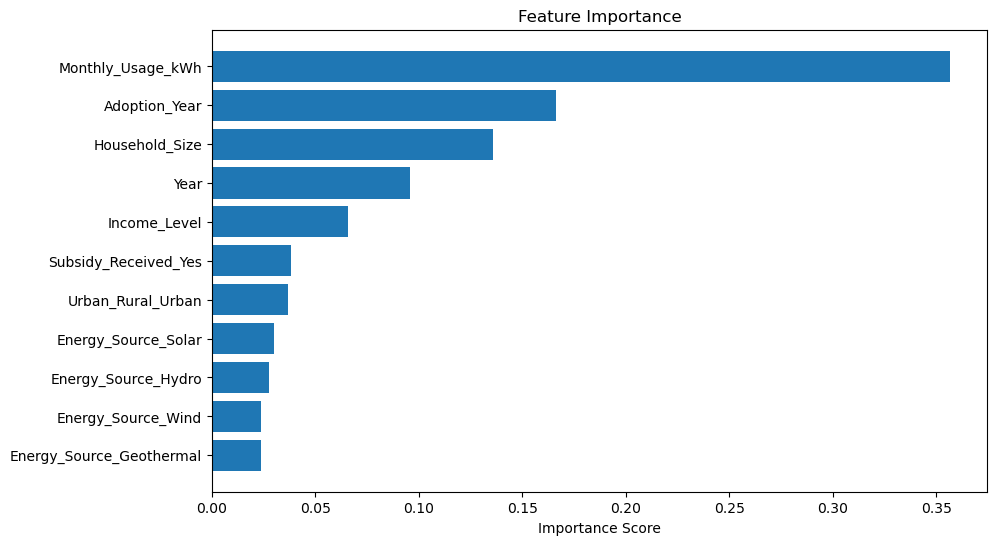

In [88]:
importances = model.feature_importances_
feature_names = x.columns

# Create a DataFrame for plotting
feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_df["Feature"], feat_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.show()


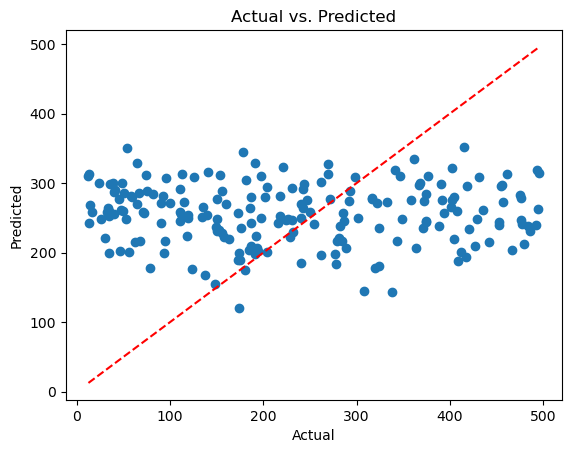

In [89]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()


In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Root MSE (RMSE):", root_mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print("R² Score:", r2_score(y_test, y_pred))


Mean Absolute Error (MAE): 126.49152749999999
Mean Squared Error (MSE): 22429.391987369545
Root MSE (RMSE): 149.76445501977278
Mean Absolute Percentage Error (MAPE): 167.18%
R² Score: -0.132605353180838


### iv) Making predictions and save the model

In [ ]:
# ,Monthly_Usage_kWh,Year,Household_Size,Income_Level,Adoption_Year,Energy_Source_Geothermal,Energy_Source_Hydro,Energy_Source_Solar,Energy_Source_Wind,Urban_Rural_Urban,Subsidy_Received_Yes
# sample = np.array([1043.49,2024,5,0,2012,False,True,False,False,True,False])
# pred = model.predict(X=[sample])
# pred

/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([73.4942])

In [92]:
import pickle

with open("RF_regressor.pkl", "wb") as f:
    pickle.dump(model, f)

## c) Custom Pytorch model

### i) Turn data into tensors

In [93]:
import torch

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
y_train_tensor[:3]

tensor([[349.6700],
        [216.0000],
        [468.3400]])

### ii) Building the model

In [94]:
from torch import nn

class RegressionModel(nn.Module):
    def __init__(self, input_shape):
        super(RegressionModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
    
    def forward(self, x):
        return self.layers(x)
    
model = RegressionModel(input_shape=X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### iii) Training and testing

In [95]:
epochs = 200
for epoch in range(epochs):
    model.train()
    preds = model(X_train_tensor)
    loss = criterion(preds, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}")

# 9. Evaluation
model.eval()
with torch.inference_mode():
    preds = model(X_test_tensor).numpy()
    truth = y_test_tensor.numpy()

    rmse = np.sqrt(mean_squared_error(truth, preds))
    r2 = r2_score(truth, preds)

    print("\n--- Evaluation ---")
    print("RMSE:", rmse)
    print("R² Score:", r2)

Epoch [20/200], Train Loss: 22272.5703
Epoch [40/200], Train Loss: 20728.6230
Epoch [60/200], Train Loss: 20555.8457
Epoch [80/200], Train Loss: 20524.7578
Epoch [100/200], Train Loss: 20522.6191
Epoch [120/200], Train Loss: 20521.5527
Epoch [140/200], Train Loss: 20520.7520
Epoch [160/200], Train Loss: 20519.9355
Epoch [180/200], Train Loss: 20518.9531
Epoch [200/200], Train Loss: 20517.9570

--- Evaluation ---
RMSE: 142.52072
R² Score: -0.02569258213043213


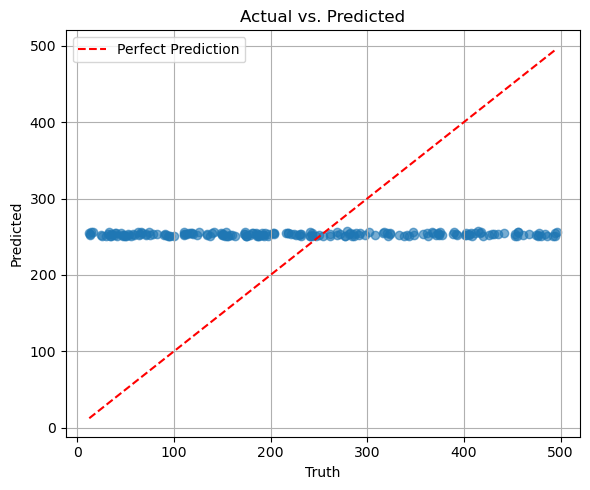

In [96]:
plt.figure(figsize=(6, 5))
plt.scatter(truth, preds, alpha=0.6)
plt.plot([truth.min(), truth.max()],
         [truth.min(), truth.max()],
         'r--', label='Perfect Prediction')
plt.xlabel("Truth")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Trying to see whats wrong

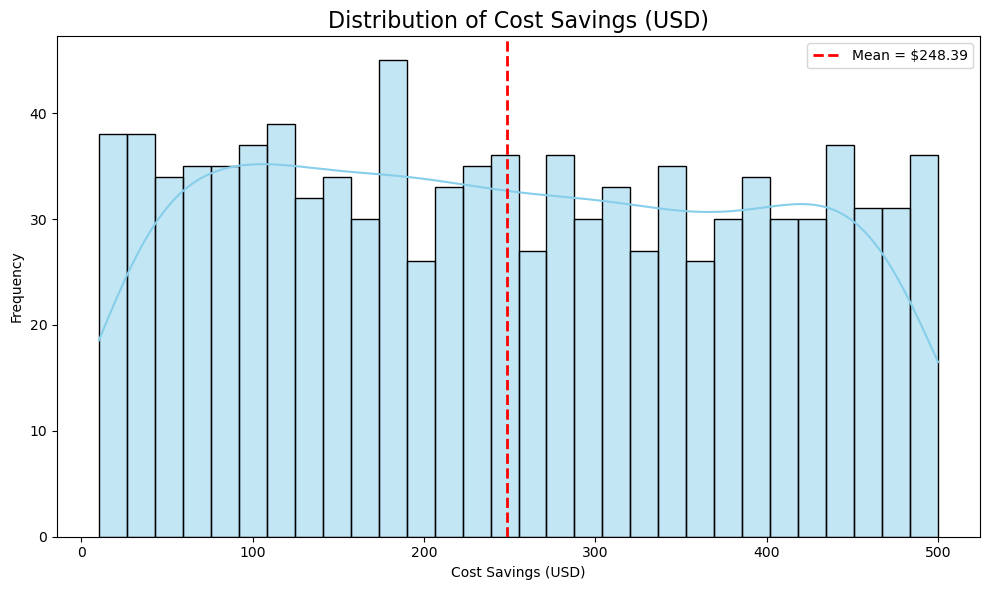

In [97]:
df = pd.read_csv("raw.csv")

# Calculate the mean
mean_cost = df["Cost_Savings_USD"].mean()

# Set up the plot
plt.figure(figsize=(10, 6))
sns.histplot(df["Cost_Savings_USD"], bins=30, kde=True, color="skyblue", edgecolor="black")

# Add a line for the mean
plt.axvline(mean_cost, color="red", linestyle="--", linewidth=2, label=f"Mean = ${mean_cost:.2f}")

# Labels and title
plt.title("Distribution of Cost Savings (USD)", fontsize=16)
plt.xlabel("Cost Savings (USD)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

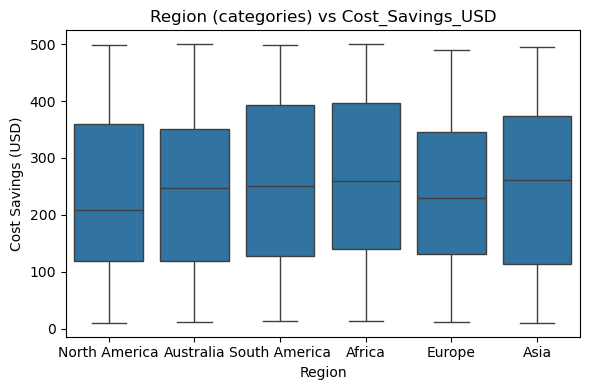

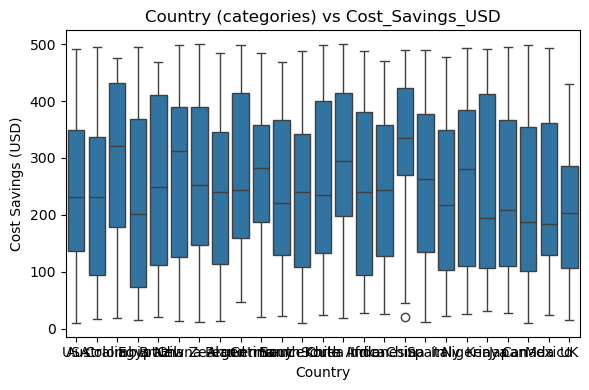

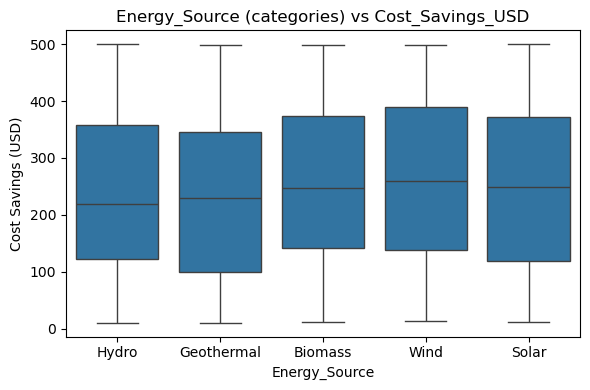

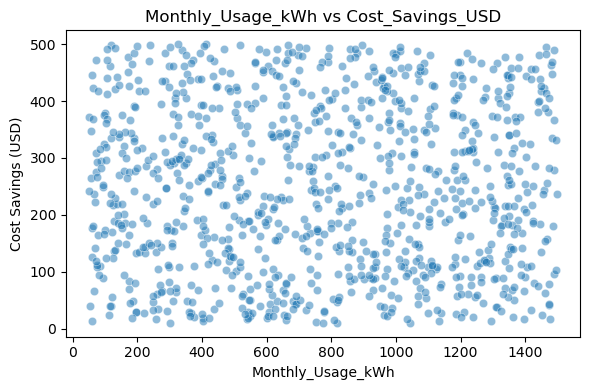

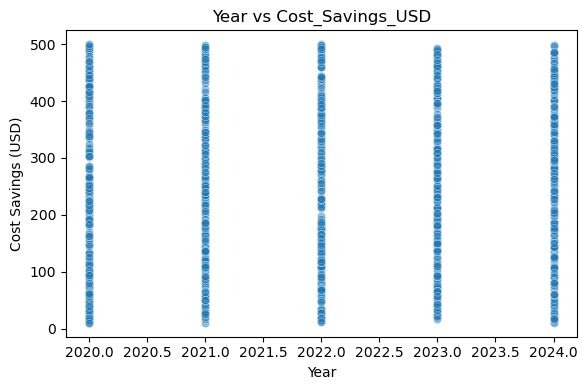

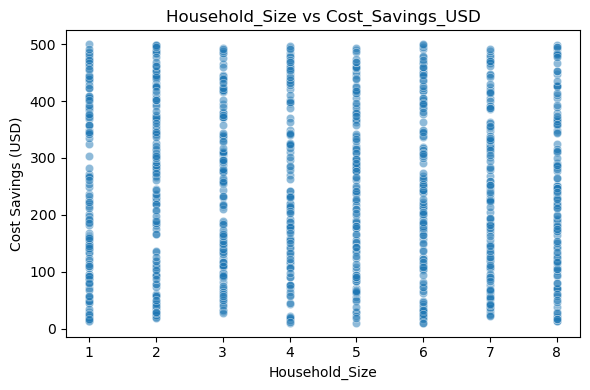

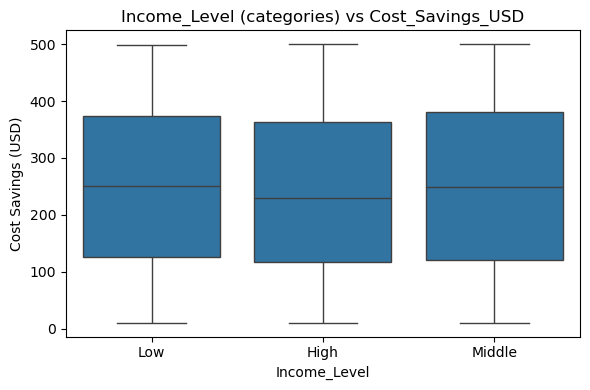

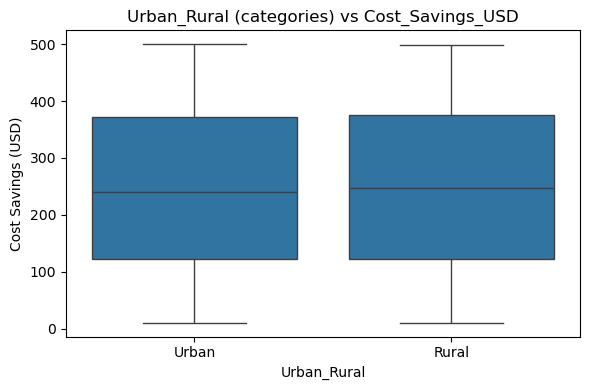

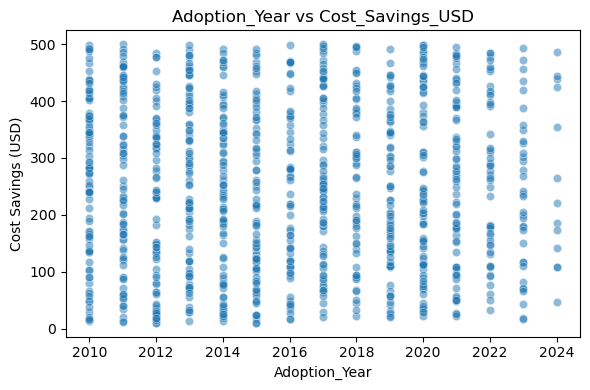

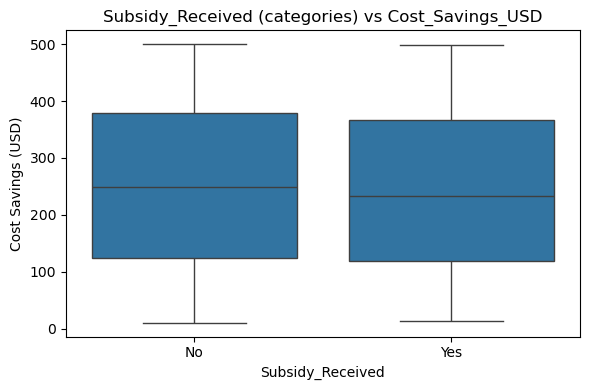

In [98]:
df = pd.read_csv("raw.csv")
# df = df.map(lambda x: 1 if x is True else (0 if x is False else x))
df = df.drop(columns=df.columns[0])  # drop index column if needed

target_col = "Cost_Savings_USD"

# Create plots
for col in df.columns:
    if col == target_col:
        continue
    
    plt.figure(figsize=(6, 4))
    
    # If column is numeric, use scatterplot
    if pd.api.types.is_numeric_dtype(df[col]):
        sns.scatterplot(data=df, x=col, y=target_col, alpha=0.5)
        plt.title(f"{col} vs {target_col}")
        plt.ylabel("Cost Savings (USD)")
        plt.xlabel(col)
    
    # If column is categorical, use boxplot
    else:
        sns.boxplot(data=df, x=col, y=target_col)
        plt.title(f"{col} (categories) vs {target_col}")
        plt.ylabel("Cost Savings (USD)")
        plt.xlabel(col)
    
    plt.tight_layout()
    plt.show()

In [99]:
import pandas as pd

# Load both CSV files
df1 = pd.read_csv("raw.csv")
df2 = pd.read_csv("Renewable_Energy_Usage_Sampled.csv")  # Replace with your second filename

# 1. Check shape
if df1.shape != df2.shape:
    print("Files differ in shape (rows or columns).")
else:
    # 2. Check column names
    if list(df1.columns) != list(df2.columns):
        print("Files differ in column names or order.")
    else:
        # 3. Check data content
        if df1.equals(df2):
            print("✅ The two CSV files are identical.")
        else:
            print("❌ The two CSV files have the same structure but different content.")


✅ The two CSV files are identical.


In [100]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

df = pd.read_csv("raw.csv")

df[['Year', 'Adoption_Year']] = df[['Year', 'Adoption_Year']].astype(str)
df.drop(["Household_ID"], axis=1, inplace=True)
# Create 2 columns with Monthly_Usage_kWh and Cost_Savings_USD per person
df['Monthly_Usage_kWh_by_Person'] = df['Monthly_Usage_kWh'] / df['Household_Size']
# df['Cost_Savings_USD_by_Person'] = df['Cost_Savings_USD'] / df['Household_Size']

# Exclude missing values - If necessary
df = df.dropna()

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for column in df.columns:
    if df[column].dtype == type(object):
        df[column] = le.fit_transform(df[column])

# Prepare feature matrix X and target vector y
X = df.drop('Cost_Savings_USD', axis=1)
y = df['Cost_Savings_USD']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model
rf = RandomForestRegressor()

# Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Make predictions
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print("MAPE: {:.2f}%".format(mape*100))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samp